<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab08_hmm1/ex-hmm1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 

# EX-HMM1

#### INSTRUCTIONS
The best way to truly understand the lowest level computations in HMMs is to make these exercises **BY HAND** first.  The problems are small enough and the computations are simple !!   
This notebook will provide you with computer solutions that only serve to VERIFY your
pencil and paper solution.  
Apart from doing the computations, there are some questions that need an interpretation of the results.

## EX-HMM1.1  Elementary HMM Computations
A silence-speech detector classifies incoming data as either speech or silence, depending on the short-time energy E of the input signal. 
The measured energy is labelled (quantized) as follows : 
> A := (E ≤30dB)   
> B := (30 dB < E ≤40 dB)    
> C := (E > 40 dB)    

Use an HMM with 2 states to model this process. 
- In the silence state, the probability of producing A, B or C is 0.7, 0.1 and 0.2 respectively. 
- In the speech state, these probabilities are 0.1, 0.5 and 0.4. 
- The probability for a transition from the silence state to the speech state or vice versa is 0.3. 

#### TASKS
1. Make a drawing of the HMM, indicate all probabilities. 
2. Make a Trellis diagram and compute both the Forward Pass score and the Viterbi score for observation \[15 35 60 25\] assuming it corresponds to an utterance embedded in silence. 
3. Align the observations against the states for the Viterbi case

### libhmm package
The *libhmm* package is specifically designed to work with Hidden Markov Models.  
It was developed for demonstration and didactic purposes.    
*libhmm* takes care of everything EXCEPT the observation probabilities.
Observation probabilities are generated by a Density object, eg. as existing in the *pyspch.stats.probdist* library, or by an object supporting the same interface.
Also observation probabilities can be fed directly as inputs.

Two classes are provided:
- hmm: hmm model class
    + attributes
        + n_states: number of states
        + initmat:  initial probabilities
        + transmat: transition probabilities (A-matrix)
        + obs_model: observation model
        + states: state names
        + prob_style: 'lin' or 'log'   work with probs or log-probs
    + methods
        + observation_prob(): compute observation probs for a given input
        + align(): find Viterbi alignment
        + fit(): Viterbi training
        + print_model()
        
- Trellis: trellis class
    + attributes
        + hmm: the hmm to use
        + end_states: admissible end_states
        + obs_probs, probs, backptrs, alignment, ... internally computed values
    + methods
        + viterbi_pass(), forward_pass():  trellis computations with Viterbi or Forward algorithm
        + backtrace(): 
        + print_trellis()
        + plot_trellis()

In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

import pyspch.stats.probdist as Densities
from pyspch.stats import libhmm

In [3]:
# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20] 
pd.reset_option('display.float_format')
pd.set_option('display.precision',3)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

## SOLUTION

### 1. Design of a 2-state silence-speech model

1. First we create the "observation model" for the two states
- we define a set of discrete probabily functions with the matching parameters

2. Next we create an HMM
- the transition matrix
    + only the 'transition probabilities' from SIL to SP and vice versa were given; the self-loop probabilities are easily computed as all transitions leaving a state must add up to 1.0
- state names
- the previously defined observation models and linking them to the correct states
- initial and final probabilities are set as follows:
    + we assume that all sequences will start in the SIL state (default assumption in the software)
    + we also assume that all sequences will end in SIL; the admmissible end states are specified in end_states[]

In [4]:
Bmat = np.array([ [0.7, 0.1, 0.2], [0.1, 0.5, 0.4] ])
dd1 = Densities.Discrete(feature_probs=[Bmat],labels=[np.array(['A','B','C'])],classes=np.array(['SIL','SP']) )

Amat = np.array([[0.7, 0.3],[0.3,0.7]])
hmm1 = libhmm.HMM(n_states=2,states=['SIL','SP'],
                   obs_model=dd1, transmat=Amat )   
# force an alignment to end in SIL state
hmm1.end_states=[0]
hmm1.print_model()



HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.7,0.3
P(SP|.),0.3,0.7



OBSERVATION MODEL

++ Feature (0) ++
 


,SIL,SP
P(A|.),0.7,0.1
P(B|.),0.1,0.5
P(C|.),0.2,0.4


### (1b) Define the Vector Quantization model for the observations
In the instructions it is given that ranges of observation values are mapped to discrete observations A, B, C.  
This is what the simple 'vq1()' function below implements.  From the continuous observations, we create a discrete observation stream.

In [5]:
# define quantizer according to the specs and quantize the continuous features
def vq1(x):
    if x <= 30: return('A')
    elif x <= 40.: return('B')
    else: return('C')
X1_c = np.array([ 15., 35., 60., 25.])
X1l = np.array([ vq1(x) for x in X1_c ])
#
print("Continuous Feature stream: ",X1_c)
print("Quantized  Feature stream: ",X1l)

Continuous Feature stream:  [15. 35. 60. 25.]
Quantized  Feature stream:  ['A' 'B' 'C' 'A']


### 2. TRELLIS computations
Note that the software works with integers as discrete labels (for efficiency reasons), 
therefore we convert the label stream (A,B,C,A) to an index stream (0,1,2,0).

In [6]:
X1i = dd1.lbl2indx(X1l.reshape(-1,1))
trellis1 = libhmm.Trellis(hmm1)
trellis1.viterbi_pass(X1i)
trellis1.print_trellis(X=X1l)


Observations



,0,1,2,3
X,A,B,C,A



Observation Probabilities



,0,1,2,3
SIL,0.7,0.1,0.2,0.7
SP,0.1,0.5,0.4,0.1



Trellis Probabilities (Viterbi)



,0,1,2,3
SIL,0.7,0.049,0.007,0.006
SP,0.0,0.105,0.029,0.002



Alignment



,0,1,2,3
VIT-ALIGN,SIL,SP,SP,SIL



Sequence Probability: 6.17e-03



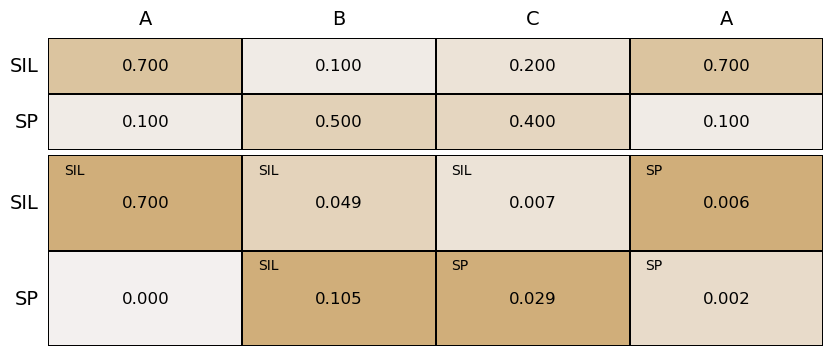

In [7]:
# The plot_trellis() module just gives another visualization option for the information in the trellis
#
trellis1.plot_trellis(xticks=X1l.flatten(),plot_obs_probs=True,plot_backptrs=True,plot_alignment=False,figsize=(10,4),
                plot_norm=True,vmin=0.,vmax=2,cmap=cmap)

## EX-HMM1.2 Training of a Discrete Density Model
You are now provided with a small training sample to retrain the model that you were given in I-1.
So you maintain the same model, but need to change the parameters.

The training samples are as follows:
> train_sample_1:  the example from above
> 
> train_sample_2:
>    - observations:     B   A   B   B   C   A  
>    - with alignment:  SIL SIL  SP  SP  SP SIL

> train_sample_3:   
>    - observations:     A   B   C   B   C   A   C   A  
>    - with alignment:  SIL SP   SP  SP  SP SIL SIL SIL

#### TASK: 
Compute new model parameters given these training samples.  If you find any data missing, use plausible assumptions.

In [8]:
# Define a small sample training data set
#
# use X1 and its alignment
S1 = trellis1.backtrace()
# use other data
X2l = ['B','A','B','B','C','A']
S2l = ['SIL','SIL','SP','SP','SP','SIL']
X3l = ['A','B','C','B','C','A','C','A']
S3l = ['SIL','SP','SP','SP','SP','SIL','SIL','SIL']
# convert everything to indices
X1 = X1i
X2 = dd1.lbl2indx(np.asarray(X2l).reshape(-1,1))
X3 = dd1.lbl2indx(np.asarray(X3l).reshape(-1,1))
S2 = [np.where(hmm1.states == s)[0][0] for s in S2l]
S3= [np.where(hmm1.states == s)[0][0] for s in S3l]
#

The training basically consists of COUNTING and then converting the counts to frequencies or probabilities.
We illustrate a few of the computations, which are easily performed by hand.

1. Initial Probabilities
> Number of Sequences: 3   
> #(Starting in Silence)= 3   ==> P(INIT=SIL) = 3/3 = 1.   
> #(Starting in Speech)= 0    ==> P(INIT=SP)  = 0/3 = 0.   
>
2. Observation Probabilities
> #(SIL): 9   
> #(A|SIL)= 7  ==> P(A|SIL) = 7/9 = 0.777   
> #(B|SIL)= 1  ==> P(B|SIL) = 1/9 = 0.111      
> #(C|SIL)= 1  ==> P(C|SIL) = 1/9 = 0.111   

The full training is done with the .fit() method below

In [9]:
# create a new model with same topology and style of observation model
hmm_trained = copy.deepcopy(hmm1)
hmm_trained.fit([X1,X2,X3],[S1,S2,S3])  
hmm_trained.print_model()


HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.5,0.333
P(SP|.),0.5,0.667



OBSERVATION MODEL

++ Feature (0) ++
 


,SIL,SP
P(A|.),0.778,0.000
P(B|.),0.111,0.556
P(C|.),0.111,0.444


### Questions

1. In the above exercises you worked with 2 HMM models.  An original one that was given and a second one that you trained on 3 example sequences.   In the first part of the exercise you computed the Viterbi score for sequence X1 on the original model.   How will the Viterbi score for X1 on the second model relate to the score on the orignal model ? (Higher, lower or unpredictable ) . Pls. Motivate

In [15]:
X1_align, X1_vit_score =  hmm_trained.vitalign(X=X1i)
print("Viterbi Score (X1) on trained model: %.2e" %( X1_vit_score) )

Viterbi Score (X1) on trained model: 1.66e-02


## Additional Materials

#### Example Training Code
Below is some minimal code implementing the training for this very specific example (single feature discrete densities)
It may be easier to read than the libhmm implementation that works for vector inputs and various observation models

In [12]:
train_set = []
train_set.append({'X':X1,'S':S1})
train_set.append({'X':X2,'S':S2})
train_set.append({'X':X3,'S':S3})

def viterbi_train(trn,n_labels=1,n_states=1):
    n_train = len(trn)
    obs_counts = np.zeros((n_states,n_labels),dtype='float')
    init_counts = np.zeros(n_states,dtype='float')
    trans_counts = np.zeros((n_states,n_states),dtype='float')
    # counting
    for i in range(0,n_train):
        init_counts[trn[i]["S"][0]] += 1.
        for j in range(len(trn[i]["X"])):
            obs_counts[trn[i]["S"][j],trn[i]["X"][j]] += 1.
            if j>0:
                trans_counts[ trn[i]["S"][j-1],trn[i]["S"][j] ] += 1.
    state_counts = np.sum(obs_counts,axis=1)
    op = obs_counts / state_counts[:,np.newaxis]
    tp = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
    ip = init_counts / np.sum(init_counts)
    return op,tp,ip

op, tp, ip = viterbi_train(train_set,n_labels=3,n_states=2)
print(op)

# create a new observation model
dd_retrained = copy.deepcopy(dd1) 
dd_retrained.feature_prob_ = [ op ]

# update all HMM parameters
hmm_retrained = copy.copy(hmm1)
hmm_retrained.transmat = tp
hmm_retrained.obs_model = dd_retrained
hmm_retrained.initmat = ip

# print the new model
hmm_retrained.print_model()

[[0.77777778 0.11111111 0.11111111]
 [0.         0.55555556 0.44444444]]

HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.5,0.333
P(SP|.),0.5,0.667



OBSERVATION MODEL

++ Feature (0) ++
 


,SIL,SP
P(A|.),0.778,0.000
P(B|.),0.111,0.556
P(C|.),0.111,0.444


####  Matching a Continuous Density Model
The **discrete density** model has symbols as observations and simple discrete density observation probabilities.
In a **continous density** model has continuous feature vectors as observations requiring a density model to map from 
observation to probability of the observation.  

In the example above we could skip the quantization step on the input and use a continuous probabilistic model instead.   
In the example we use a Gaussian density.  We set parameters (means and variances) that are consistent with the discrete model described above.  These parameters were nor given, nor trained, just smart guessed.   
Except for the computation of the FRAME PROBABILITIES all other steps are identical to the discrete density model.

#### Questions
You may observe that the Viterbi alignment for the discrete and continuous model is the same. The likelihoods are different.  
- will discrete and continuous model always give identical Viterbi alignments ?
- Why are the likelihoods different ? Can they even be compared ?

In [13]:
def gpdf(x,mu,sig):
    z = (x-mu)/sig
    ss = 1./(np.sqrt(2.*np.pi)*sig)
    return(ss * np.exp(-0.5*z*z))
def cdprobs(xlist):
    pdf1 = np.array([gpdf(x,20,10) for x in xlist]).reshape(-1,1)
    pdf2 = np.array([gpdf(x,50,20) for x in xlist]).reshape(-1,1)
    return( np.hstack([pdf1 , pdf2]) )

In [14]:
X2 =  [15., 35., 60.,25.]
X2probs = cdprobs(X2)
print(X2probs)

[[3.52065327e-02 4.31386594e-03]
 [1.29517596e-02 1.50568716e-02]
 [1.33830226e-05 1.76032663e-02]
 [3.52065327e-02 9.13245427e-03]]


In [15]:
# in this code we feed directly observation probabilities into the HMM
hmm2 =  libhmm.HMM(n_states=2,states=['SIL','SP'],transmat=Amat,obs_model=None ) 
hmm2.print_model()
trellis2 = libhmm.Trellis(hmm2)
trellis2.viterbi_pass(X2probs)
trellis2.print_trellis()


HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.7,0.3
P(SP|.),0.3,0.7



OBSERVATION MODEL

Nothing to print


Observation Probabilities



,0,1,2,3
SIL,0.035,0.013,1.338e-05,0.035
SP,0.004,0.015,1.760e-02,0.009



Trellis Probabilities (Viterbi)



,0,1,2,3
SIL,0.035,3.192e-04,2.990e-09,2.070e-08
SP,0.000,1.590e-04,1.960e-06,1.253e-08



Alignment



,0,1,2,3
VIT-ALIGN,SIL,SP,SP,SIL



Sequence Probability: 2.07e-08

